##  imports necessary libraries and loads the dataset.

In [42]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [43]:
image_path = '../input/flickr8k/Images'

In [44]:
data = pd.read_csv("../input/flickr8k/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


## Text Preprocessing: <br>

**Lowercasing**: Converting all text to lowercase ensures uniformity and reduces the vocabulary size by treating words like "Hello" and "hello" as the same. <br>
**Removing Special Characters**: Special characters such as punctuation marks, symbols, and numbers often do not contribute much to the semantics of the text and can be safely removed. Removing them simplifies the vocabulary and reduces noise. <br>
**Tokenization**: Breaking down the text into individual words or tokens facilitates further processing. Each token represents a unit of meaning and allows us to apply techniques like one-hot encoding or word embeddings.<br>
**Adding Start and End Sequence Tokens**: Adding special tokens like "startseq" and "endseq" helps the model learn when to start and stop generating captions. This provides context to the model and aids in the training process, ensuring that the generated captions have proper beginnings and endings.<br>
## Image Preprocessing:<br>

**Loading Images**: Loading images is the first step in image preprocessing. We read image files from disk into memory to manipulate and extract features.<br>
**Resizing**: Resizing images to a fixed size ensures uniformity in input dimensions, which is required for feeding them into neural networks. This step prevents computational inefficiency and helps maintain consistency across images.<br>
**Normalization**: Normalizing pixel values to a range between 0 and 1 is a common practice in deep learning. It helps stabilize and speed up the training process by ensuring that all input features have a similar scale. Additionally, normalization prevents numerical instability in gradient-based optimization algorithms.<br>

In [45]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"../input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

In [47]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

## __Preprocessed Text__

In [48]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

## Tokenization: <br>

Conversion to Integers: Neural networks operate on numerical data. Tokenization converts words (or tokens) in the captions to unique integers, allowing the model to process textual data.<br>
Mapping Words to Integers: Each word in the vocabulary is assigned a unique integer index. This mapping enables the model to represent words as dense vectors or one-hot encodings, which are suitable for neural network computations.<br>
Efficient Representation: Integer representations are more memory-efficient compared to raw text. They allow for faster processing and reduce memory consumption during training and inference.<br>


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

print(tokenizer.texts_to_sequences([captions[1]])[0])
print("Vocabulary size: {}".format(vocab_size))
print("Max length: {}".format(max_length))


[1, 18, 315, 63, 195, 116, 2]
Vocabulary size: 8485
Max length: 34


In [50]:
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w') as f:
    f.write(tokenizer_json)

In [66]:
from keras.preprocessing.text import tokenizer_from_json
import json

# Load the tokenizer from the JSON file
with open('tokenizer.json') as f:
    tokenizer_json = f.read()
    loaded_tokenizer = tokenizer_from_json(tokenizer_json)

# Verify that the tokenizer has been loaded correctly
print(loaded_tokenizer.texts_to_sequences([captions[1]])[0])


[1, 18, 315, 63, 195, 116, 2]


## Extracting image features using a pre-trained DenseNet201 model serves several purposes: <br>

1. **Feature Extraction:**<br>
   - DenseNet201 is a deep convolutional neural network (CNN) architecture that has been pre-trained on a large dataset (e.g., ImageNet) to classify images into various categories.<br>
   - The model has learned to extract hierarchical features from images at different levels of abstraction through its convolutional layers.<br>
   - By truncating the classifier head (i.e., the fully connected layers responsible for image classification), we remove the part of the model that maps the extracted features to specific class labels. This leaves us with the feature extraction part of the network.<br>

2. **Transfer Learning:**<br>
   - Transfer learning leverages the knowledge learned by a model on a source task (e.g., image classification) and applies it to a different but related task (e.g., image captioning).<br>
   - By using the pre-trained DenseNet201 model, we benefit from the learned image representations without the need to train the entire model from scratch. This can save significant time and computational resources.<br>

3. **Second Last Layer's Output:**<br>
   - The second last layer of the DenseNet201 model typically contains high-level, semantically rich features extracted from the input image.<br>
   - These features capture important visual information about the content of the image, such as shapes, textures, and object compositions.<br>
   - Using the output of the second last layer as image features provides a compact and informative representation of the image, which can be further processed by subsequent layers in the image captioning model.<br>

Overall, extracting image features from a pre-trained DenseNet201 model allows us to utilize powerful visual representations learned from a large-scale image classification task, enabling better performance and generalization in the image captioning task.<br>

In [37]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|██████████| 8091/8091 [10:21<00:00, 13.02it/s]


In [38]:
import pickle
with open('image_features.pkl', 'wb') as f:
    pickle.dump(features, f)

print('Features extracted and saved successfully.')

Features extracted and saved successfully.


In [51]:
import pickle

# Load the features from the file
with open('/kaggle/working/image_features.pkl', 'rb') as f:
    features = pickle.load(f)

print('Features loaded successfully.')


Features loaded successfully.


## implemented a custom data generator for several reasons:

Efficient Memory Usage: Loading the entire dataset into memory can be memory-intensive, especially for large datasets. By using a data generator, we can load batches of data into memory during training, which reduces memory usage. <br>

Dynamic Data Loading: In scenarios where the dataset is too large to fit into memory, a data generator allows us to dynamically load batches of data from disk during training, enabling training on large datasets.<br>

Tokenization and Preprocessing: The data generator preprocesses the captions by tokenizing them and prepares input-output pairs required for training the model. This preprocessing step ensures that the data is in the correct format expected by the model.<br>

Batch Processing: Training deep learning models with mini-batches is a common practice as it helps in stabilizing training and improving convergence. The data generator generates batches of samples along with their corresponding labels, making it suitable for training using mini-batch gradient descent.<br>

Shuffling: The data generator shuffles the data before each epoch, which helps in preventing the model from memorizing the order of samples and potentially overfitting to the training data.<br>

Overall, using a custom data generator enhances training efficiency, reduces memory overhead, and ensures that the model receives properly preprocessed data during training.<br>

In [ ]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

## designed the image captioning model with the following components for specific reasons: <br>

1. **Image Input**: The model needs to understand the content of the image to generate relevant captions. Hence, we include an image input to provide the visual information to the model. In this case, we used the image features extracted from a pre-trained convolutional neural network (DenseNet201) as input.<br>

2. **Caption Input**: To generate captions, the model requires information about the words already generated. Therefore, we include a caption input to feed the partial captions during training and inference. This allows the model to generate subsequent words based on the context of the input image and the words generated so far.<br>

3. **Embedding Layers**: Both the image features and the caption input need to be converted into dense vector representations that the model can work with. Hence, we use embedding layers to learn these representations. The embedding layers map each word in the vocabulary to a high-dimensional vector space where words with similar meanings are closer to each other.<br>

4. **LSTM Layer**: Long Short-Term Memory (LSTM) networks are well-suited for sequence generation tasks like language modeling and captioning. LSTM cells maintain a memory state that allows them to capture long-range dependencies in the input sequences. By including an LSTM layer, the model learns to generate captions by sequentially predicting the next word based on the current word and the context learned from previous words.<br>

5. **Dense Layers**: The output of the LSTM layer is passed through one or more dense layers to transform the LSTM's hidden states into the vocabulary space. These dense layers allow the model to learn complex mappings between the LSTM outputs and the words in the vocabulary.<br>

The combination of these components enables the model to understand the content of the input image, generate captions word by word based on the visual and contextual information, and produce coherent and relevant descriptions of the images.<br>

In [ ]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [52]:
from keras.models import load_model

# Load the model from the file
loaded_model = load_model('/kaggle/input/model-file/model.h5')

# Print the model summary to verify it's loaded correctly
loaded_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 1920)]       0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 256)          491776      input_12[0][0]                   
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 34)]         0                                            
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 1, 256)       0           dense_5[0][0]                    
____________________________________________________________________________________________

## We used custom data generators to train the model for several reasons: <br>

**Efficient Memory Usage**: Custom data generators allow us to load and preprocess data in batches, which helps in efficient memory usage. This is particularly important when dealing with large datasets that may not fit entirely into memory.<br>

**On-the-fly Data Augmentation**: Data generators can perform on-the-fly data augmentation, such as random rotations, flips, and shifts, which helps in increasing the diversity of training data and reduces overfitting.<br>

Dynamic Dataset Handling: Data generators can handle datasets of any size, allowing us to work with datasets that are too large to fit into memory at once.<br>

**Customization**: We can customize data generators according to our specific requirements, such as tokenizing text data, padding sequences, and preprocessing images, which are essential steps in the image captioning task.<br>

Using validation data during training allows us to monitor the model's performance on unseen data and helps in preventing overfitting. By evaluating the model on validation data after each epoch, we can make decisions such as early stopping or adjusting hyperparameters to improve generalization performance.<br>

In [ ]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [ ]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

# Train

In [ ]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 [==============================] - 240s 441ms/step - loss: 5.1305 - val_loss: 4.2463

Epoch 00001: val_loss improved from inf to 4.24633, saving model to model.h5
Epoch 2/50
537/537 [==============================] - 51s 95ms/step - loss: 4.1831 - val_loss: 3.9067

Epoch 00002: val_loss improved from 4.24633 to 3.90670, saving model to model.h5
Epoch 3/50
537/537 [==============================] - 49s 92ms/step - loss: 3.9115 - val_loss: 3.7757

Epoch 00003: val_loss improved from 3.90670 to 3.77570, saving model to model.h5
Epoch 4/50
537/537 [==============================] - 50s 93ms/step - loss: 3.7523 - val_loss: 3.6894

Epoch 00004: val_loss improved from 3.77570 to 3.68942, saving model to model.h5
Epoch 5/50
537/537 [==============================] - 50s 93ms/step - loss: 3.6342 - val_loss: 3.6484

Epoch 00005: val_loss improved from 3.68942 to 3.64841, saving model to model.h5
Epoch 6/50
537/537 [==============================] - 50s 93ms/step - loss: 3.5398

## **Caption Generation Utility Functions**
- Utility functions to generate the captions of input images at the inference time.

In [85]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [86]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

## **Taking 15 Random Samples for Caption Prediction**

In [87]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [88]:
image_path = '../input/flickr8k/Images'
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(loaded_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

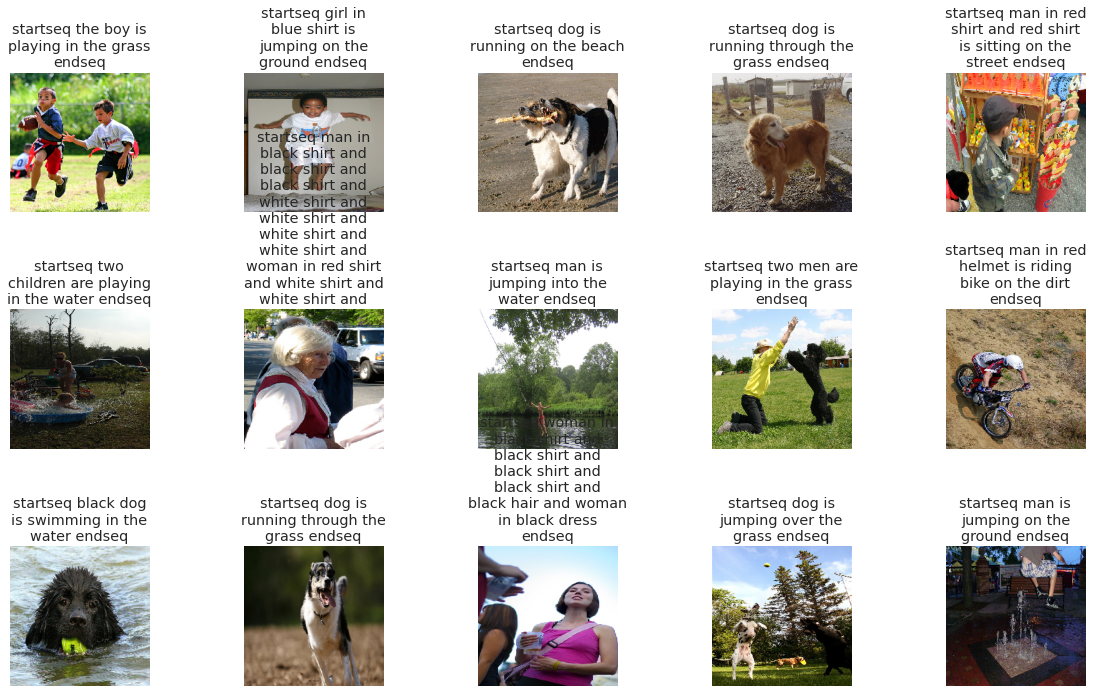

In [89]:
display_images(samples)

# convert text to speech

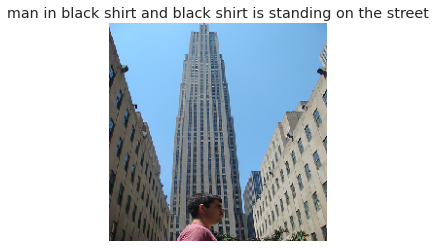

In [94]:
from gtts import gTTS
import IPython.display as ipd
import matplotlib.pyplot as plt

def predict_caption_with_speech(caption_model, image_path, tokenizer, max_length, features, img_size=224):
    
    model = DenseNet201()
    fe = Model(inputs=model.input, outputs=model.layers[-2].output)

    img = load_img(image_path, target_size=(img_size, img_size))
    img_array = img_to_array(img)
    img_array = img_array / 255.
    img_array = np.expand_dims(img_array, axis=0)
    feature = fe.predict(img_array, verbose=0)
    
    in_text = "startseq"
    
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        y_pred = caption_model.predict([feature, sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text += " " + word
        
        if word == 'endseq':
            break
    
    # Remove the startseq and endseq tokens
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    
    # Convert the caption to speech
    tts = gTTS(final_caption, lang='en')
    tts.save("caption.mp3")
    
    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.title(final_caption)
    plt.show()
    
    # Play the speech
    return ipd.Audio("caption.mp3", autoplay=True)

# Predict the caption for the given image path and convert it to speech
image_path = '/kaggle/input/flickr8k/Images/1032460886_4a598ed535.jpg'
speech_output = predict_caption_with_speech(loaded_model, image_path, tokenizer, 200, features)
speech_output


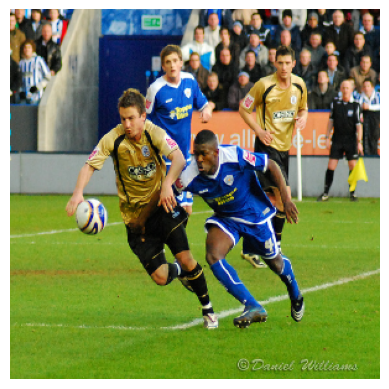

/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:857: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:857: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:857: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Predicted Caption:  a football player in a uniform is running on the field
Audio content written to file 'output.mp3'


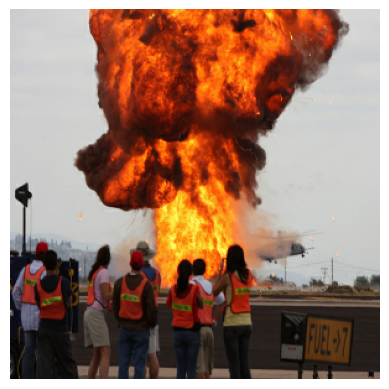

/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:857: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:857: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:857: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Predicted Caption:  a group of people are standing on a street
Audio content written to file 'output.mp3'


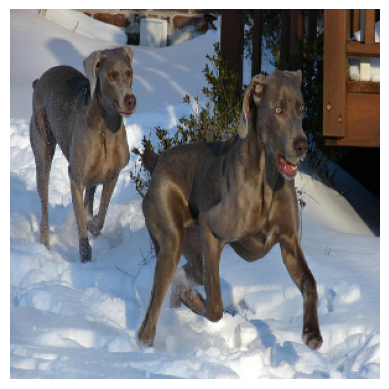

/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:857: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:857: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:857: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Predicted Caption:  a brown dog is running through the snow
Audio content written to file 'output.mp3'
